In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Load and Prepare Data Set<a id="1-2"></a>

In [2]:
# load data set
data = pd.read_csv('/Users/kartikeyac/Downloads/crypto-markets.csv', parse_dates=['date'],index_col='date')

In [3]:
# display appointment data set
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


According to Business Insider, the top cryptocurrencies to invest in are:
1. Bitcoin (BTC)
2. Ethereum (ETH)
3. Litecoin (LTC)
4. Bitcoin Cash (BCH)
5. Ripple (XRP)
6. Monero (XMR)
7. Zcash (ZEC)

So we will do some analysis and prediction for these 7 cryptocurrencies. 

In [4]:
# select Bitcoin (BTC), Litecoin (LTC), Ethereum (ETH), Zcash (ZEC), Ripple (XRP), Monero (XMR) and Bitcoin Cash (BCH)
data = data[data.symbol.isin(['BTC', 'LTC', 'ETH', 'ZEC', 'XRP', 'XMR', 'BCH'])]

In [5]:
# display total number of records for the 7 cryptocurrencies
data.name.value_counts()

Bitcoin         2042
Litecoin        2042
XRP             1944
Monero          1653
Ethereum        1211
Zcash            762
Bitcoin Cash     495
Name: name, dtype: int64

In [6]:
# display data volumn and types 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10149 entries, 2013-04-28 to 2018-11-29
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   slug         10149 non-null  object 
 1   symbol       10149 non-null  object 
 2   name         10149 non-null  object 
 3   ranknow      10149 non-null  int64  
 4   open         10149 non-null  float64
 5   high         10149 non-null  float64
 6   low          10149 non-null  float64
 7   close        10149 non-null  float64
 8   volume       10149 non-null  float64
 9   market       10149 non-null  float64
 10  close_ratio  10149 non-null  float64
 11  spread       10149 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 1.0+ MB


## 2. Data Quality Assessment<a id="2"></a>

### Check Missing Values<a id="2-1"></a>

In [7]:
# check if data set contains missing values
print(data.isnull().sum())

# assert that there are no missing values
assert data.notnull().all().all()

slug           0
symbol         0
name           0
ranknow        0
open           0
high           0
low            0
close          0
volume         0
market         0
close_ratio    0
spread         0
dtype: int64


No missing value exist in this data set.

### Check Duplicated Values<a id="2-2"></a>

In [8]:
# check if data set contains duplicated records
print(data.duplicated().sum())

0


There is no duplicated appointments record in this data set. The data is clean.

## 3. Exploratory Data Analysis and Feature Engineering<a id="3"></a>

Check market capitalization and transaction volume for each cryptocurrency we choose.

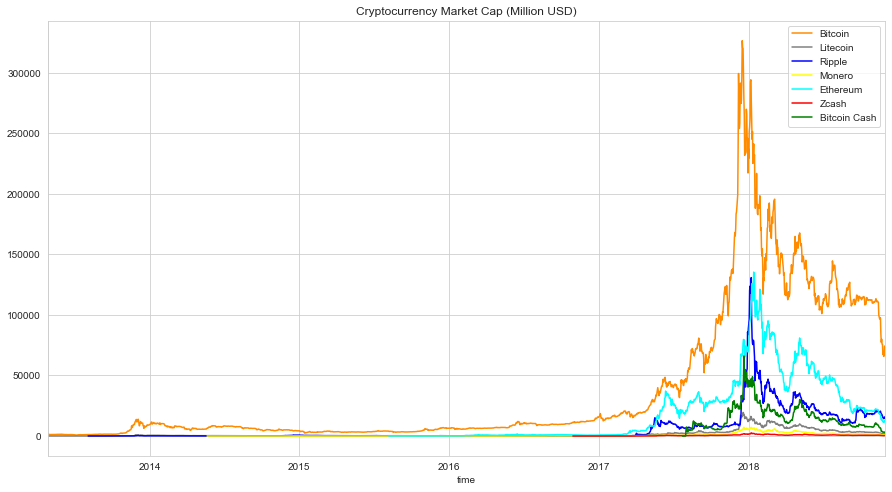

In [9]:
# plot market capitalization
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['market']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['market']/1000000).plot(color='grey', label='Litecoin')
(ripple['market']/1000000).plot(color='blue', label='Ripple')
(monero['market']/1000000).plot(color='yellow', label='Monero')
(ethereum['market']/1000000).plot(color='cyan', label='Ethereum')
(zcash['market']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['market']/1000000).plot(color='green', label='Bitcoin Cash')

plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Market Cap (Million USD)')
plt.show()

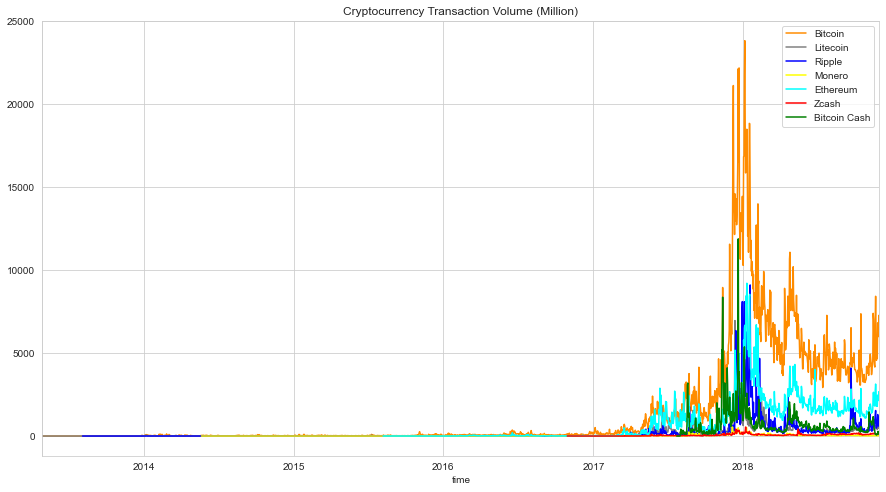

In [10]:
# plot transaction volume
plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['volume']/1000000).plot(color='blue', label='Ripple')
(monero['volume']/1000000).plot(color='yellow', label='Monero')
(ethereum['volume']/1000000).plot(color='cyan', label='Ethereum')
(zcash['volume']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['volume']/1000000).plot(color='green', label='Bitcoin Cash')

plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million)')
plt.show()

In [11]:
data_m = data['2017-12-01':'2017-12-31']

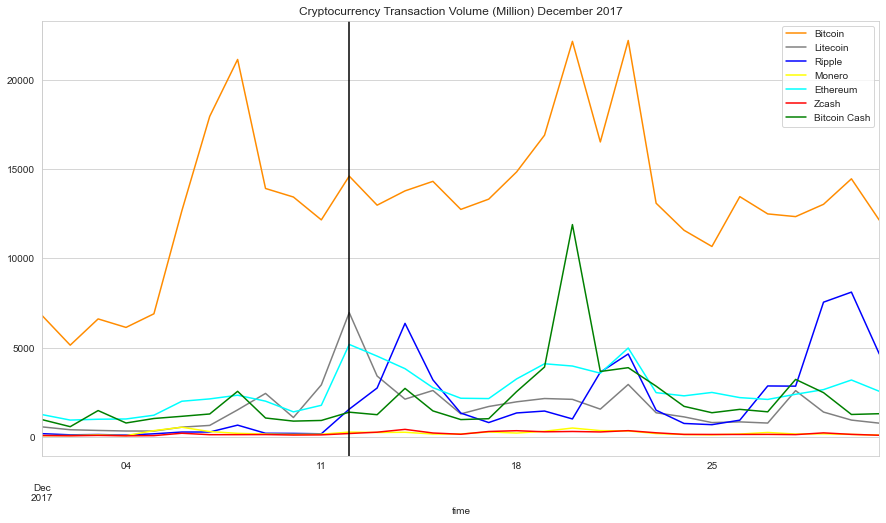

In [14]:
bitcoin = data_m[data_m['symbol']=='BTC']
litecoin = data_m[data_m['symbol']=='LTC']
ripple = data_m[data_m['symbol']=='XRP']
monero = data_m[data_m['symbol']=='XMR']
ethereum = data_m[data_m['symbol']=='ETH']
zcash = data_m[data_m['symbol']=='ZEC']
bitcoin_cash = data_m[data_m['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['volume']/1000000).plot(color='blue', label='Ripple')
(monero['volume']/1000000).plot(color='yellow', label='Monero')
(ethereum['volume']/1000000).plot(color='cyan', label='Ethereum')
(zcash['volume']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['volume']/1000000).plot(color='green', label='Bitcoin Cash')
plt.axvline(dt.datetime(2017, 12, 12),color='black')
plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million) December 2017')
plt.show()

In [15]:
data = data['2017-01-01':]
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2017-01-01,bitcoin,BTC,Bitcoin,1,963.66,1003.08,958.70,998.33,147775008.0,1.605041e+10,0.8930,44.38
2017-01-02,bitcoin,BTC,Bitcoin,1,998.62,1031.39,996.70,1021.75,222184992.0,1.642902e+10,0.7221,34.69
2017-01-03,bitcoin,BTC,Bitcoin,1,1021.60,1044.08,1021.60,1043.84,185168000.0,1.678637e+10,0.9893,22.48
2017-01-04,bitcoin,BTC,Bitcoin,1,1044.40,1159.42,1044.40,1154.73,344945984.0,1.857187e+10,0.9592,115.02
2017-01-05,bitcoin,BTC,Bitcoin,1,1156.73,1191.10,910.42,1013.38,510199008.0,1.630025e+10,0.3668,280.68


### Price Fluctuation of Cryptocurrencies<a id="3-2"></a>

Check opening, closing, highest, and lowest price for each of the cryptocurrency.

In [16]:
data['oc_diff']=data['close']-data['open']
data.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread,oc_diff
date,,,,,,,,,,,,,
2017-01-01,bitcoin,BTC,Bitcoin,1,963.66,1003.08,958.70,998.33,147775008.0,1.605041e+10,0.8930,44.38,34.67
2017-01-02,bitcoin,BTC,Bitcoin,1,998.62,1031.39,996.70,1021.75,222184992.0,1.642902e+10,0.7221,34.69,23.13
2017-01-03,bitcoin,BTC,Bitcoin,1,1021.60,1044.08,1021.60,1043.84,185168000.0,1.678637e+10,0.9893,22.48,22.24
2017-01-04,bitcoin,BTC,Bitcoin,1,1044.40,1159.42,1044.40,1154.73,344945984.0,1.857187e+10,0.9592,115.02,110.33
2017-01-05,bitcoin,BTC,Bitcoin,1,1156.73,1191.10,910.42,1013.38,510199008.0,1.630025e+10,0.3668,280.68,-143.35


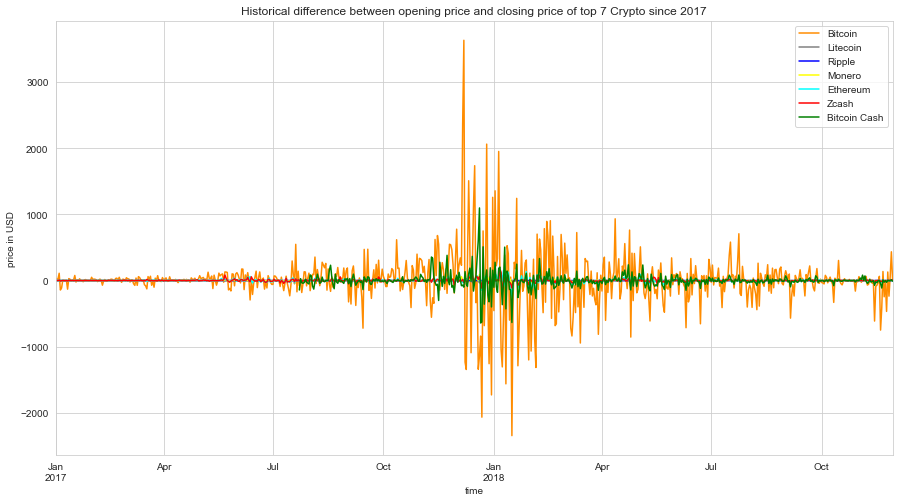

In [17]:
# Difference between opening and closing price
data['oc_diff']=data['close']-data['open']
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['oc_diff']).plot(color='darkorange', label='Bitcoin')
(litecoin['oc_diff']).plot(color='grey', label='Litecoin')
(ripple['oc_diff']).plot(color='blue', label='Ripple')
(monero['oc_diff']).plot(color='yellow', label='Monero')
(ethereum['oc_diff']).plot(color='cyan', label='Ethereum')
(zcash['oc_diff']).plot(color='red', label='Zcash')
(bitcoin_cash['oc_diff']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical difference between opening price and closing price of top 7 Crypto since 2017')
plt.legend()
plt.show()

In [18]:
# Average difference for each cryptocurrency
ave_diff={'bitcoin':[(bitcoin['oc_diff']).mean()],
          'litecoin':[(litecoin['oc_diff']).mean()],
          'ripple':[(ripple['oc_diff']).mean()],
          'monero':[(monero['oc_diff']).mean()],
          'ethereum':[(ethereum['oc_diff']).mean()],
          'zcash':[(zcash['oc_diff']).mean()],
          'bitcoin_cash':[(bitcoin_cash['oc_diff']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bitcoin,litecoin,ripple,monero,ethereum,zcash,bitcoin_cash
avg.diff,4.27596,0.009255,0.000599,0.030158,0.026891,0.082708,-1.158364


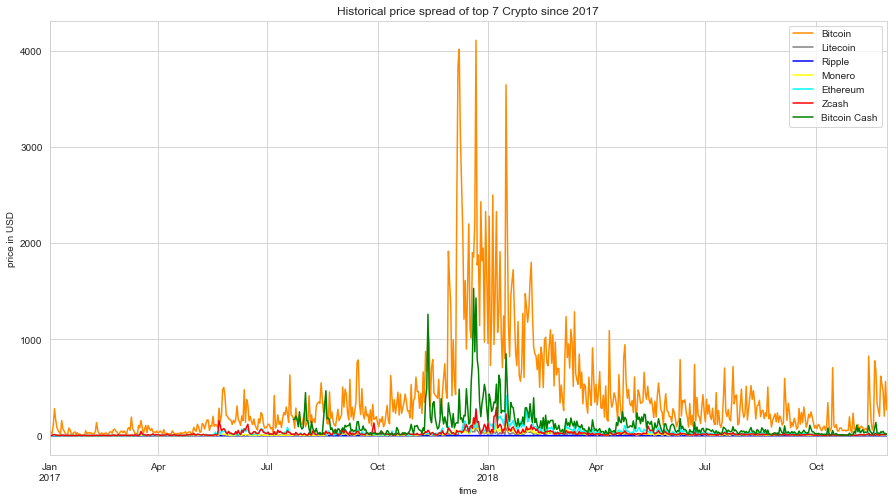

In [19]:
# Differences of daily highest price and lowest price
plt.figure(figsize=(15,8))
(bitcoin['spread']).plot(color='darkorange', label='Bitcoin')
(litecoin['spread']).plot(color='grey', label='Litecoin')
(ripple['spread']).plot(color='blue', label='Ripple')
(monero['spread']).plot(color='yellow', label='Monero')
(ethereum['spread']).plot(color='cyan', label='Ethereum')
(zcash['spread']).plot(color='red', label='Zcash')
(bitcoin_cash['spread']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical price spread of top 7 Crypto since 2017')
plt.legend()
plt.show()

In [20]:
# Average spread for each cryptocurrency
ave_spread={'bitcoin':[(bitcoin['spread']).mean()],
          'litecoin':[(litecoin['spread']).mean()],
          'ripple':[(ripple['spread']).mean()],
          'monero':[(monero['spread']).mean()],
          'ethereum':[(ethereum['spread']).mean()],
          'zcash':[(zcash['spread']).mean()],
          'bitcoin_cash':[(bitcoin_cash['spread']).mean()]}
pd.DataFrame(ave_spread, index=['avg.spread'])

,bitcoin,litecoin,ripple,monero,ethereum,zcash,bitcoin_cash
avg.spread,392.605774,7.699441,0.052908,12.898911,30.863553,24.140587,115.406889


### Moving Averages and Price Trend<a id="3-3"></a>

In [21]:
# calculate 5-day moving averages
btc = bitcoin[['close']]
btc.columns = ['BTC']
btc_ma=btc.rolling(window=5).mean()

ltc = litecoin[['close']]
ltc.columns = ['LTC']
ltc_ma=ltc.rolling(window=5).mean()

xrp = ripple[['close']]
xrp.columns = ['XRP']
xrp_ma=xrp.rolling(window=5).mean()

xmr = monero[['close']]
xmr.columns = ['XMR']
xmr_ma=xmr.rolling(window=5).mean()

eth = ethereum[['close']]
eth.columns = ['ETH']
eth_ma=eth.rolling(window=5).mean()

zec = zcash[['close']]
zec.columns = ['ZEC']
zec_ma=zec.rolling(window=5).mean()

bch = bitcoin_cash[['close']]
bch.columns = ['BCH']
bch_ma=bch.rolling(window=5).mean()

# create matrix of close price only for later use
close = pd.concat([btc,ltc,xrp,xmr,eth,zec,bch], axis=1)
close_ma = pd.concat([btc_ma,ltc_ma,xrp_ma,xmr_ma,eth_ma,zec_ma,bch_ma], axis=1)
close_ma.tail()

,BTC,LTC,XRP,XMR,ETH,ZEC,BCH
date,,,,,,,
2018-11-25,4241.190,31.828,0.406209,63.568,123.330,76.060,204.024
2018-11-26,4076.582,30.776,0.387769,60.424,117.656,72.148,193.242
2018-11-27,3967.538,30.550,0.374586,58.678,114.316,71.040,186.760
2018-11-28,3949.600,31.044,0.371212,58.056,114.144,71.510,183.288
2018-11-29,4029.218,31.960,0.372057,58.624,114.954,75.552,183.346


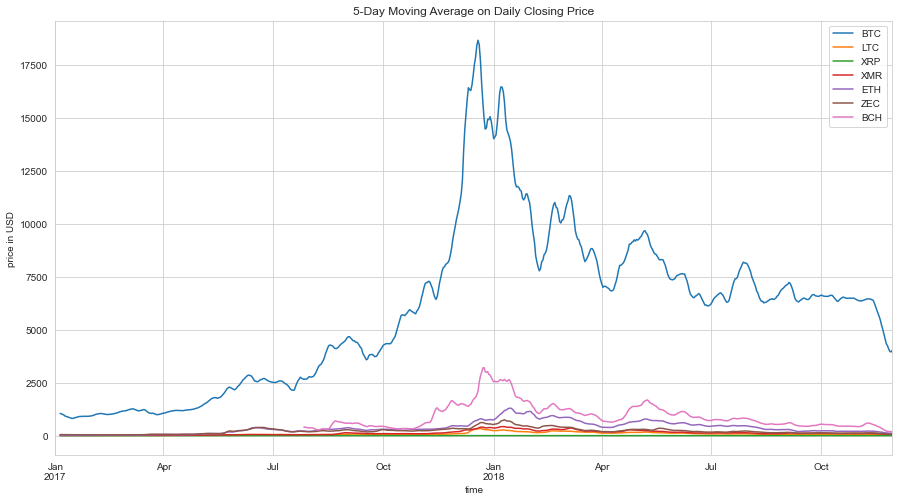

In [22]:
# plot moving average for closing price for cryptocurrencies
close_ma.plot(figsize=(15,8))
plt.title('5-Day Moving Average on Daily Closing Price')
plt.xlabel('time')
plt.ylabel('price in USD')
plt.show()

### Market Prices of Cryptocurrencies<a id="3-4"></a>

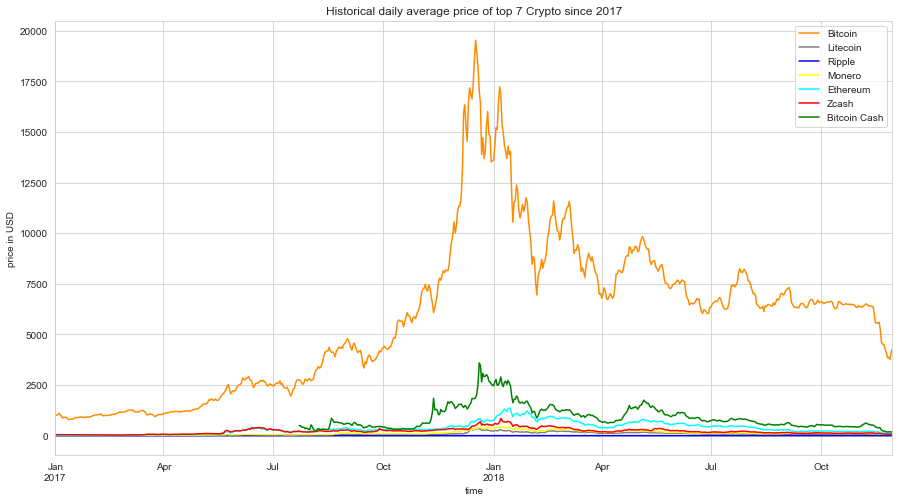

In [23]:
# calculate daily average price
data['daily_avg'] = ( data['high'] + data['low']) / 2
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['daily_avg']).plot(color='darkorange', label='Bitcoin')
(litecoin['daily_avg']).plot(color='grey', label='Litecoin')
(ripple['daily_avg']).plot(color='blue', label='Ripple')
(monero['daily_avg']).plot(color='yellow', label='Monero')
(ethereum['daily_avg']).plot(color='cyan', label='Ethereum')
(zcash['daily_avg']).plot(color='red', label='Zcash')
(bitcoin_cash['daily_avg']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical daily average price of top 7 Crypto since 2017')
plt.legend()
plt.show()

#### Plot individual daily open, high, low, close prices

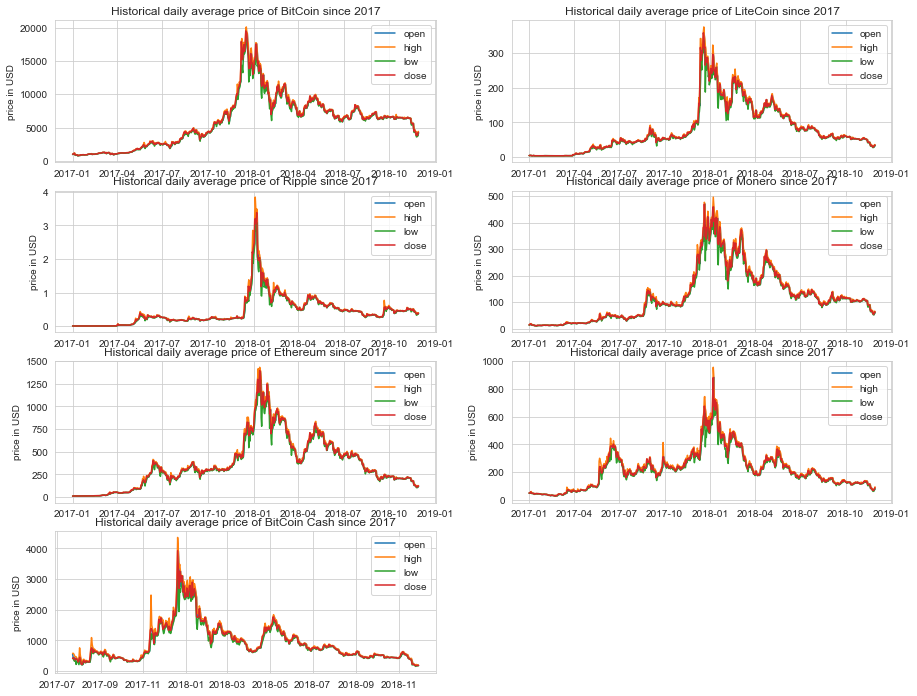

In [24]:
plt.figure(figsize=(15, 12))
plt.subplot(4,2,1)
plt.plot(bitcoin[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,2)
plt.plot(litecoin[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of LiteCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,3)
plt.plot(ripple[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ripple since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,4)
plt.plot(monero[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Monero since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,5)
plt.plot(ethereum[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ethereum since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,6)
plt.plot(zcash[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Zcash since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,7)
plt.plot(bitcoin_cash[['open','high','low','close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin Cash since 2017')
plt.legend(['open','high','low','close'])

plt.show()

#### Check Pearson correlation coefficient to prove if BitCoin price influences price of other cryptocurrencies

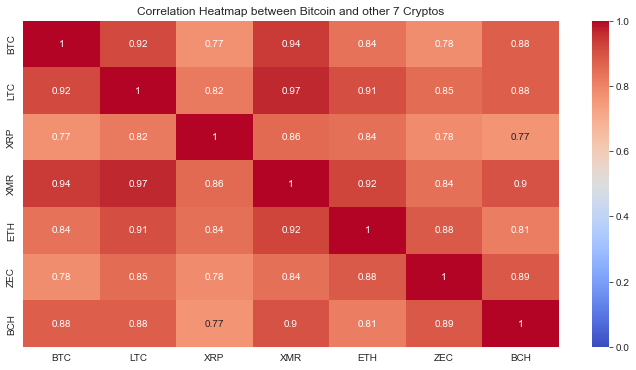

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other 7 Cryptos')
plt.show()

### Return Ratio<a id="3-5"></a>

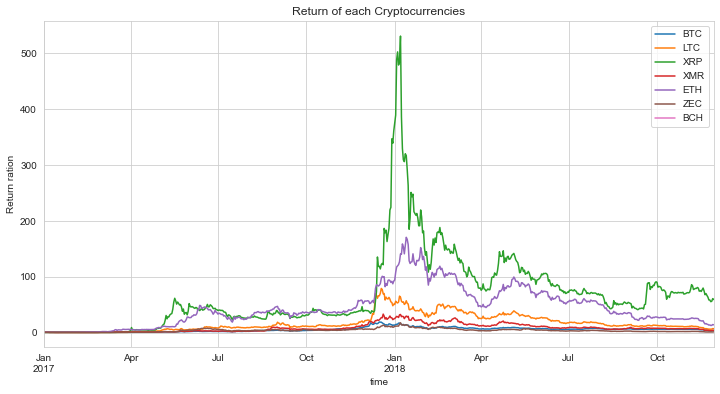

In [26]:
returns = close.apply(lambda x: x/x[0])
returns.plot(figsize=(12,6))
plt.ylabel('Return ration')
plt.xlabel('time')
plt.title('Return of each Cryptocurrencies')
plt.show()

### Candlestick Charts Using Plotly (BitCoin)<a id="3-6"></a>

In [27]:
increasing_color = '#17BECF'
decreasing_color = '#7F7F7F'
data_plotly = []
layout = {
    'xaxis': {
        'rangeselector': {
            'visible': True
        }
    },
    # Adding a volume bar chart for candlesticks is a good practice usually
    'yaxis': {
        'domain': [0, 0.2],
        'showticklabels': False
    },
    'yaxis2': {
        'domain': [0.2, 0.8]
    },
    'legend': {
        'orientation': 'h',
        'y': 0.9,
        'yanchor': 'bottom'
    },
    'margin': {
        't': 40,
        'b': 40,
        'r': 40,
        'l': 40
    }
}

# Defining main chart
trace0 = go.Candlestick(
    x=bitcoin.index, open=bitcoin['open'], high=bitcoin['high'],
    low=bitcoin['low'], close=bitcoin['close'],
    yaxis='y2', name='bitcoin',
    increasing=dict(line=dict(color=increasing_color)),
    decreasing=dict(line=dict(color=decreasing_color)),
)

data_plotly.append(trace0)

# Adding some range buttons to interact
rangeselector = {
    'visible': True,
    'x': 0,
    'y': 0.8,
    'buttons': [
        {'count': 1, 'label': 'reset', 'step': 'all'},
        {'count': 6, 'label': '6 mo', 'step': 'month', 'stepmode': 'backward'},
        {'count': 3, 'label': '3 mo', 'step': 'month', 'stepmode': 'backward'},
        {'count': 1, 'label': '1 mo', 'step': 'month', 'stepmode': 'backward'},
    ]
}

layout['xaxis'].update(rangeselector=rangeselector)

# Setting volume bar chart colors
colors = []
for i, _ in enumerate(bitcoin.index):
    if i != 0:
        if bitcoin['close'].iloc[i] > bitcoin['close'].iloc[i-1]:
            colors.append(increasing_color)
        else:
            colors.append(decreasing_color)
    else:
        colors.append(decreasing_color)

trace1 = go.Bar(
    x=bitcoin.index, y=bitcoin['volume'],
    marker=dict(color=colors),
    yaxis='y', name='Volume'
)

data_plotly.append(trace1)

# Adding Moving Average
def moving_average(interval, window_size=10):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

trace2 = go.Scatter(
    x=bitcoin.index[5:-5], y=moving_average(bitcoin['close'])[5:-5],
    yaxis='y2', name='Moving Average',
    line=dict(width=1)
)

data_plotly.append(trace2)

# Adding boilinger bands
def bollinger_bands(price, window_size=10, num_of_std=5):
    rolling_mean = price.rolling(10).mean()
    rolling_std = price.rolling(10).std()
    upper_band = rolling_mean + (rolling_std * 5)
    lower_band = rolling_mean - (rolling_std * 5)
    return upper_band, lower_band

bb_upper, bb_lower = bollinger_bands(bitcoin['close'])

trace3 = go.Scatter(
    x=bitcoin.index, y=bb_upper,
    yaxis='y2', line=dict(width=1),
    marker=dict(color='#ccc'), hoverinfo='none',
    name='Bollinger Bands',
    legendgroup='Bollinger Bands'
)
data_plotly.append(trace3)

trace4 = go.Scatter(
    x=bitcoin.index, y=bb_lower,
    yaxis='y2', line=dict(width=1),
    marker=dict(color='#ccc'), hoverinfo='none',
    name='Bollinger Bands', showlegend=False,
    legendgroup='Bollinger Bands'
)
data_plotly.append(trace4)
fig = go.Figure(data=data_plotly, layout=layout)
py.iplot(fig, filename='bitcoin-candlestick')

## 4. Building Models - Predicting Price for Cryptocurrencies<a id="4"></a>

In [28]:
# droping 'slug' and 'name' as we can just use 'symbol', and droping 'ranknow'.
data=data.drop(['slug', 'name', 'ranknow'], axis=1)

# Bitcoin (BTC)
BTC = data[data.symbol == 'BTC'].copy() #extract data for BTC from dataset
BTC['daily_avg_After_Month']=BTC['daily_avg'].shift(-30) #find daily average after a month ends
X_BTC = BTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1) #drop 3 columns which are of no use
y_BTC = BTC.dropna()['daily_avg_After_Month'] #drop daily avg after month column
X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC = train_test_split(X_BTC, y_BTC, test_size=0.2, random_state=43) #create train-test split
X_forecast_BTC =  BTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1) #Drop last 30 days after training

# Ethereum (ETH)
ETH = data[data.symbol == 'ETH'].copy()
ETH['daily_avg_After_Month']=ETH['daily_avg'].shift(-30)
X_ETH = ETH.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_ETH = ETH.dropna()['daily_avg_After_Month']
X_train_ETH, X_test_ETH, y_train_ETH, y_test_ETH = train_test_split(X_ETH, y_ETH, test_size=0.2, random_state=43)
X_forecast_ETH =  ETH.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Litecoin (LTC)
LTC = data[data.symbol == 'LTC'].copy()
LTC['daily_avg_After_Month']=LTC['daily_avg'].shift(-30)
X_LTC = LTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_LTC = LTC.dropna()['daily_avg_After_Month']
X_train_LTC, X_test_LTC, y_train_LTC, y_test_LTC = train_test_split(X_LTC, y_LTC, test_size=0.2, random_state=43)
X_forecast_LTC =  LTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Bitcoin Cash (BCH)
BCH = data[data.symbol == 'BCH'].copy()
BCH['daily_avg_After_Month']=BCH['daily_avg'].shift(-30)
X_BCH = BCH.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_BCH = BCH.dropna()['daily_avg_After_Month']
X_train_BCH, X_test_BCH, y_train_BCH, y_test_BCH = train_test_split(X_BCH, y_BCH, test_size=0.2, random_state=43)
X_forecast_BCH =  BCH.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Ripple (XRP)
XRP = data[data.symbol == 'XRP'].copy()
XRP['daily_avg_After_Month']=XRP['daily_avg'].shift(-30)
X_XRP = XRP.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_XRP = XRP.dropna()['daily_avg_After_Month']
X_train_XRP, X_test_XRP, y_train_XRP, y_test_XRP = train_test_split(X_XRP, y_XRP, test_size=0.2, random_state=43)
X_forecast_XRP =  XRP.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Monero (XMR)
XMR = data[data.symbol == 'XMR'].copy()
XMR['daily_avg_After_Month']=XMR['daily_avg'].shift(-30)
X_XMR = XMR.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_XMR = XMR.dropna()['daily_avg_After_Month']
X_train_XMR, X_test_XMR, y_train_XMR, y_test_XMR = train_test_split(X_XMR, y_XMR, test_size=0.2, random_state=43)
X_forecast_XMR =  XMR.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Zcash (ZEC)
ZEC = data[data.symbol == 'ZEC'].copy()
ZEC['daily_avg_After_Month']=ZEC['daily_avg'].shift(-30)
X_ZEC = ZEC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_ZEC = ZEC.dropna()['daily_avg_After_Month']
X_train_ZEC, X_test_ZEC, y_train_ZEC, y_test_ZEC = train_test_split(X_ZEC, y_ZEC, test_size=0.2, random_state=43)
X_forecast_ZEC =  ZEC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

### Applying Machine Learning Models<a id="4-2"></a>

In [29]:
# define regression function
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500),
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=500, min_samples_split=5),
        'Bayesian Ridge': BayesianRidge(),
        'Elastic Net CV': ElasticNetCV()
    }

    for name, clf in Regressor.items():
        print(name)
        clf.fit(X_train, y_train)
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):.2f}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):.2f}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):.2f}')
        print()

In [30]:
# Bitcoin (BTC)
print('Bitcoin (BTC):')
regression(X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC)

Bitcoin (BTC):
Random Forest Regressor
R2: 0.92
MAE: 811.38
MSE: 1981267.10

Gradient Boosting Regressor
R2: 0.91
MAE: 844.72
MSE: 2029177.65

ExtraTrees Regressor
R2: 0.93
MAE: 760.93
MSE: 1608384.06

Bayesian Ridge
R2: 0.67
MAE: 1622.02
MSE: 7817720.47

Elastic Net CV
R2: 0.61
MAE: 1857.99
MSE: 9186745.49



In [31]:
# Ethereum (ETH)
print('Ethereum (ETH):')
regression(X_train_ETH, X_test_ETH, y_train_ETH, y_test_ETH)

Ethereum (ETH):
Random Forest Regressor
R2: 0.89
MAE: 64.13
MSE: 9820.29

Gradient Boosting Regressor
R2: 0.88
MAE: 65.02
MSE: 10869.67

ExtraTrees Regressor
R2: 0.90
MAE: 59.43
MSE: 9051.93

Bayesian Ridge
R2: 0.61
MAE: 128.48
MSE: 34998.86

Elastic Net CV
R2: 0.65
MAE: 131.20
MSE: 31620.10



In [32]:
# Litecoin (LTC)
print('Litecoin (LTC):')
regression(X_train_LTC, X_test_LTC, y_train_LTC, y_test_LTC)

Litecoin (LTC):
Random Forest Regressor
R2: 0.73
MAE: 16.90
MSE: 1496.34

Gradient Boosting Regressor
R2: 0.65
MAE: 20.28
MSE: 1988.45

ExtraTrees Regressor
R2: 0.73
MAE: 17.53
MSE: 1542.22

Bayesian Ridge
R2: 0.40
MAE: 36.19
MSE: 3347.14

Elastic Net CV
R2: 0.41
MAE: 36.21
MSE: 3335.32



In [33]:
# Bitcoin Cash (BCH)
print('Bitcoin Cash (BCH):')
regression(X_train_BCH, X_test_BCH, y_train_BCH, y_test_BCH)

Bitcoin Cash (BCH):
Random Forest Regressor
R2: 0.81
MAE: 258.09
MSE: 121403.44

Gradient Boosting Regressor
R2: 0.79
MAE: 265.55
MSE: 134112.32

ExtraTrees Regressor
R2: 0.85
MAE: 239.23
MSE: 97964.84

Bayesian Ridge
R2: 0.32
MAE: 541.09
MSE: 435625.11

Elastic Net CV
R2: 0.31
MAE: 552.45
MSE: 442785.53



In [34]:
# Ripple (XRP)
print('Ripple (XRP):')
regression(X_train_XRP, X_test_XRP, y_train_XRP, y_test_XRP)

Ripple (XRP):
Random Forest Regressor
R2: 0.67
MAE: 0.14
MSE: 0.11

Gradient Boosting Regressor
R2: 0.68
MAE: 0.16
MSE: 0.11

ExtraTrees Regressor
R2: 0.56
MAE: 0.17
MSE: 0.15

Bayesian Ridge
R2: 0.17
MAE: 0.27
MSE: 0.28

Elastic Net CV
R2: 0.17
MAE: 0.27
MSE: 0.28



In [35]:
# Monero (XMR)
print('Monero (XMR):')
regression(X_train_XMR, X_test_XMR, y_train_XMR, y_test_XMR)

Monero (XMR):
Random Forest Regressor
R2: 0.80
MAE: 30.45
MSE: 2641.29

Gradient Boosting Regressor
R2: 0.76
MAE: 31.08
MSE: 3114.37

ExtraTrees Regressor
R2: 0.82
MAE: 30.03
MSE: 2306.74

Bayesian Ridge
R2: 0.59
MAE: 51.88
MSE: 5314.11

Elastic Net CV
R2: 0.58
MAE: 52.46
MSE: 5393.12



In [36]:
# Zcash (ZEC)
print('Zcash (ZEC):')
regression(X_train_ZEC, X_test_ZEC, y_train_ZEC, y_test_ZEC)

Zcash (ZEC):
Random Forest Regressor
R2: 0.93
MAE: 27.23
MSE: 1654.13

Gradient Boosting Regressor
R2: 0.93
MAE: 27.70
MSE: 1567.10

ExtraTrees Regressor
R2: 0.94
MAE: 25.10
MSE: 1319.42

Bayesian Ridge
R2: 0.46
MAE: 88.31
MSE: 12648.82

Elastic Net CV
R2: 0.44
MAE: 89.30
MSE: 13065.29



As for all the five algorithms, I will end up taking Extra Trees Regressor for all cryptos but XRP and LTC, since this algorithm perform better than all other algorithms in all indicators(R2, MAE and MSE).

For XRP and LTC, the Random Forest Regressor perform distinctly better than all other algorithms. 

### Prices Prediction<a id="4-3"></a>

In [37]:
# define prediction function
def prediction(name, X, y, X_forecast):
    if name in ['XRP', 'LTC']:
        model = RandomForestRegressor(n_estimators=200)
    else:
        model = ExtraTreesRegressor(n_estimators=500, min_samples_split=5)
    model.fit(X, y)
    target = model.predict(X_forecast)
    return target

In [38]:
# calculate forecasted prices for next 30 days
forecasted_BTC = prediction('BTC', X_BTC, y_BTC, X_forecast_BTC)
forecasted_ETH = prediction('ETH', X_ETH, y_ETH, X_forecast_ETH)
forecasted_LTC = prediction('LTC', X_LTC, y_LTC, X_forecast_LTC)
forecasted_BCH = prediction('BCH', X_BCH, y_BCH, X_forecast_BCH)
forecasted_XRP = prediction('XRP', X_XRP, y_XRP, X_forecast_XRP)
forecasted_XMR = prediction('XMR', X_XMR, y_XMR, X_forecast_XMR)
forecasted_ZEC = prediction('ZEC', X_ZEC, y_ZEC, X_forecast_ZEC)

In [39]:
# define index for next 30 days
last_date=data.iloc[-1].name
modified_date = last_date + dt.timedelta(days=1)
new_date = pd.date_range(modified_date,periods=30,freq='D')

# assign prediction to newly defined index
forecasted_BTC = pd.DataFrame(forecasted_BTC, columns=['daily_avg'], index=new_date)
forecasted_ETH = pd.DataFrame(forecasted_ETH, columns=['daily_avg'], index=new_date)
forecasted_LTC = pd.DataFrame(forecasted_LTC, columns=['daily_avg'], index=new_date)
forecasted_BCH = pd.DataFrame(forecasted_BCH, columns=['daily_avg'], index=new_date)
forecasted_XRP = pd.DataFrame(forecasted_XRP, columns=['daily_avg'], index=new_date)
forecasted_XMR = pd.DataFrame(forecasted_XMR, columns=['daily_avg'], index=new_date)
forecasted_ZEC = pd.DataFrame(forecasted_ZEC, columns=['daily_avg'], index=new_date)

# combine historical price and predicted price
bitcoin = pd.concat([data[data['symbol']=='BTC'][['daily_avg']], forecasted_BTC])
litecoin = pd.concat([data[data['symbol']=='LTC'][['daily_avg']], forecasted_LTC])
ripple = pd.concat([data[data['symbol']=='XRP'][['daily_avg']], forecasted_XRP])
monero = pd.concat([data[data['symbol']=='XMR'][['daily_avg']], forecasted_XMR])
ethereum = pd.concat([data[data['symbol']=='ETH'][['daily_avg']], forecasted_ETH])
zcash = pd.concat([data[data['symbol']=='ZEC'][['daily_avg']], forecasted_ZEC])
bitcoin_cash = pd.concat([data[data['symbol']=='BCH'][['daily_avg']], forecasted_BCH])

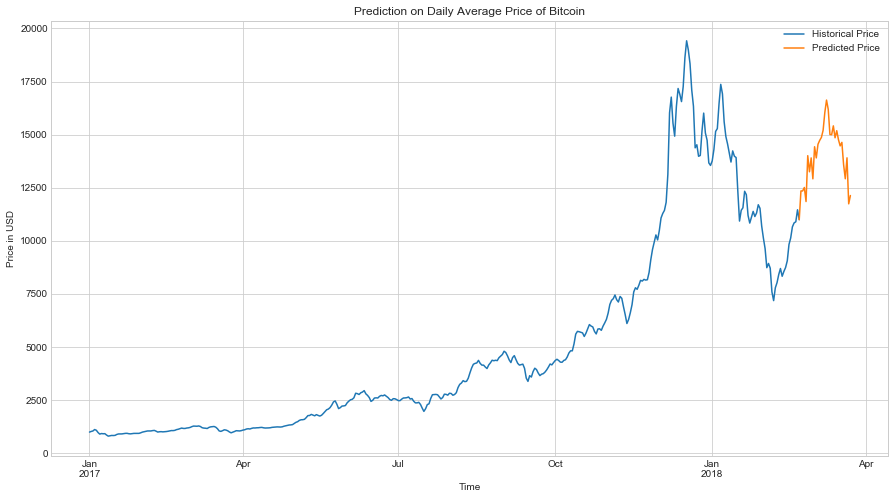

In [40]:
plt.figure(figsize=(15,8))
(bitcoin[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()

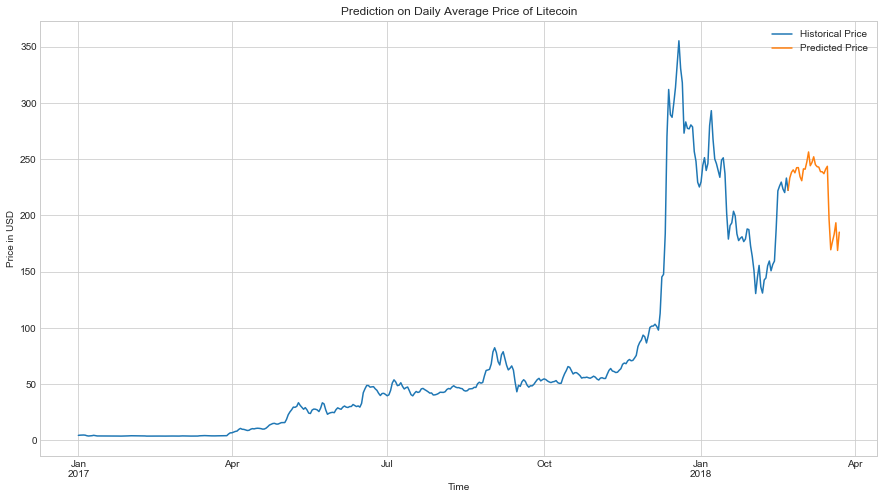

In [41]:
plt.figure(figsize=(15,8))
(litecoin[:-30]['daily_avg']).plot(label='Historical Price')
(litecoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Litecoin')
plt.legend()
plt.show()

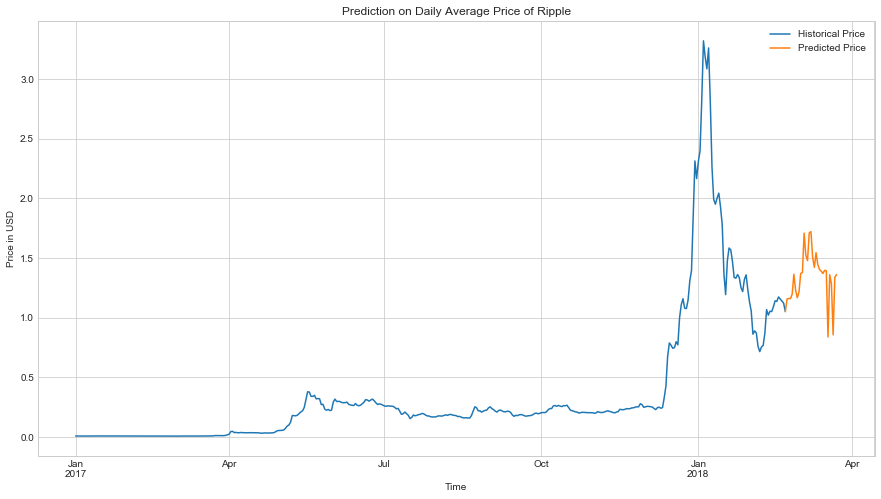

In [42]:
plt.figure(figsize=(15,8))
(ripple[:-30]['daily_avg']).plot(label='Historical Price')
(ripple[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Ripple')
plt.legend()
plt.show()

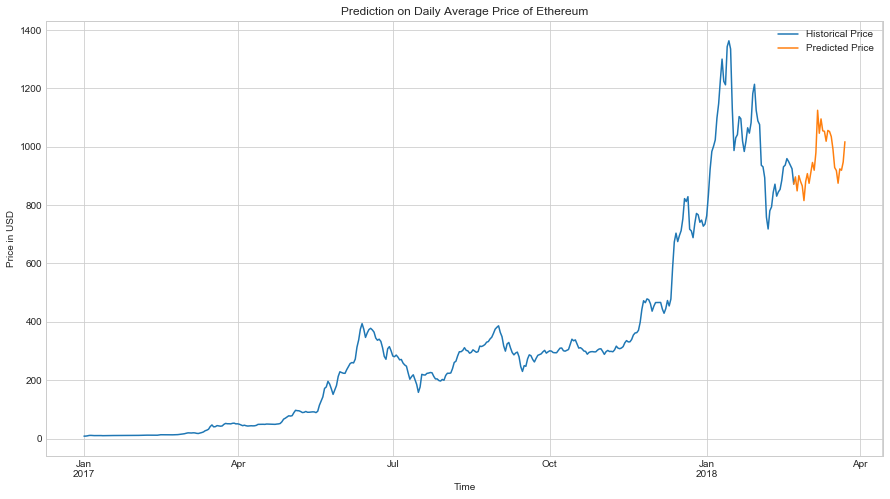

In [43]:
plt.figure(figsize=(15,8))
(ethereum[:-30]['daily_avg']).plot(label='Historical Price')
(ethereum[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Ethereum')
plt.legend()
plt.show()

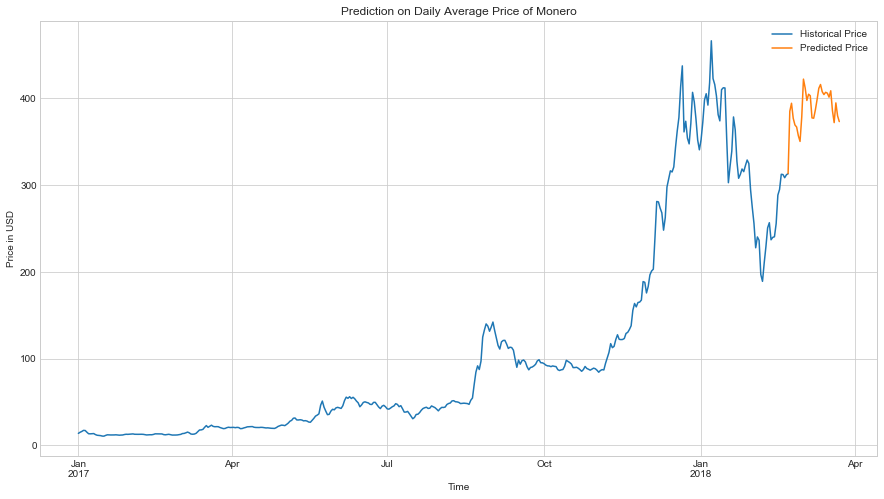

In [44]:
plt.figure(figsize=(15,8))
(monero[:-30]['daily_avg']).plot(label='Historical Price')
(monero[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Monero')
plt.legend()
plt.show()

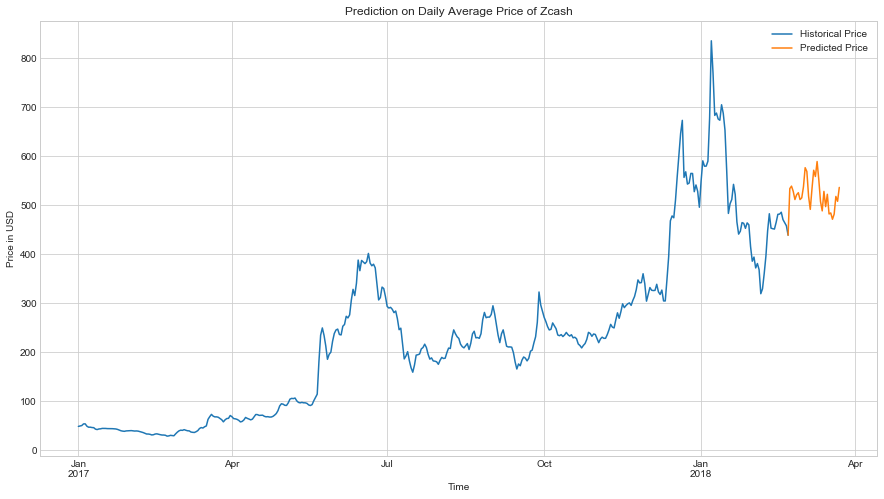

In [45]:
plt.figure(figsize=(15,8))
(zcash[:-30]['daily_avg']).plot(label='Historical Price')
(zcash[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Zcash')
plt.legend()
plt.show()

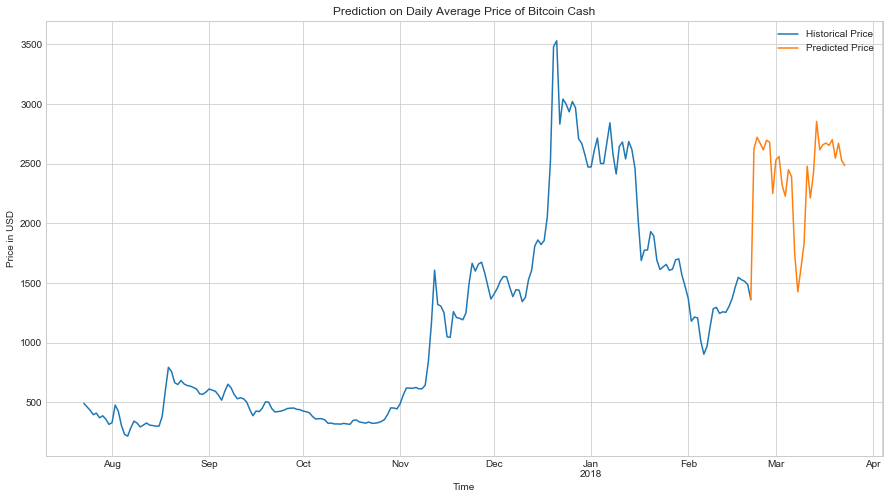

In [46]:
plt.figure(figsize=(15,8))
(bitcoin_cash[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin_cash[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin Cash')
plt.legend()
plt.show()